[Back to manual](../karta-manual.html)

[Back to introduction](../introduction.html)

# Karta tutorial


## Introduction

*Karta* provides a lightweight set of tools for performing analyses of
geographical data. The organization of karta is around a set of container
classes for vector and raster data with builtin methods for common tasks. This
tutorial provides a brief introduction to some of the main parts of karta.

Should you come across any mistakes, let me know, or even better, provide a pull
request on [Github](https://github.com/fortyninemaps/karta)!

The following examples are shown using Python 3, however *Karta* is supported on
both Python 2.7+ and Python 3.4+.

## Definitions

**Vector data** are data that can be treated as a set of connected or
disconnected vertices. Examples might be road networks, a set of borders,
geophysical survey lines, or the path taken by a bottle floating in an ocean
current. In *Karta*, these data are classified as belonging to *Point*,
*Multipoint*, *Line* or *Polygon* classes. Some questions that might be asked
of vector data include

- which of these points are contained in this polygon?
- how many times and where do these lines intersect each other?
- what is the average distance travelled by a particle?
- what municipalities does this river flow through?

**Raster data**, in contrast, is data that are typically thought of in terms
of pixels or a grid of values covering a surface. Examples might be an
elevation map, satellite image, or an upstream area map. Depending on what the
data represents, one might

- ask what are the slope and aspect of this DEM?
- downsample or interpolate a grid
- apply a pansharpening algorithm to multispectral satellite imagery
- extract an elevation profile along a path

The term **coordinate reference system** refers to a system of relating measurements
on a coordinate system to actual positions on Earth. *Karta* includes methods for
geodetic calculations and basic support of projected and geographical
coordinates, as well as coordinate system classes backed by *pyproj*.

## Vector data

Let's experiment with some vector data.

In [1]:
from karta.vector import Point, Multipoint, Line, Polygon

The `Point`, `Multipoint`, `Line`, and `Polygon` classes can all be instantiated
by providing vertices, and optionally, associated data and metadata.

In [2]:
pt = Point((-123.1, 49.25))
print(pt)

Point(-123.1, 49.25)


In [3]:
mpt = Multipoint([(-122.93, 48.62),
                  (-123.10, 48.54),
                  (-122.90, 48.49),
                  (-122.81, 48.56)])
print(mpt)

In [4]:
line = Line([(-124.35713, 49.31437),
             (-124.37857, 49.31720),
             (-124.39442, 49.31833),
             (-124.40311, 49.31942),
             (-124.41052, 49.32203),
             (-124.41681, 49.32477),
             (-124.42278, 49.32588)])
print(line)

In [5]:
poly = Polygon([(-25.41, 67.03),
                (-24.83, 62.92),
                (-12.76, 63.15),
                (-11.44, 66.82)])
print(poly)

Each geometrical object now contains a vertex/vertices in a cartesian plane.

We may be interested in determining whether our point is within our polygon

In [6]:
print(poly.contains(pt))       # False

False


In [7]:
pt2 = Point((-25, 65))
print(poly.contains(pt2))      # True

True


or whether our line crosses the polygon

In [8]:
print(line.intersects(poly))   # False

False


There are methods for computing the nearest vertex to an external point, or the nearest point on an edge to an external point:

In [9]:
pt = Point((0.0, 60.0))
print(poly.nearest_vertex_to(pt))
print(poly.nearest_on_boundary(pt))

2
Point(-12.301580009598124, 64.42454648846582)


The vertices of multiple vertex objects can be iterated through and sliced:

In [10]:
section = line[2:-2]
for pt in section:
    print(pt.vertex)

(-124.39442, 49.31833)
(-124.40311, 49.31942)
(-124.41052, 49.32203)


A slice that takes part of a polygon returns a line.

In [11]:
print(poly[:2])

Points have a `distance` that calculates the distance to another point. However, if we do

In [12]:
pt = Point((-123.1, 49.25))
pt2 = Point((-70.66, 41.52))
print(pt.distance(pt2))

53.00666467530286


this probably isn't what we wanted. Be default, geometries in Karta use a planar cartesian coordinate system. If our positions are meant to be geographical coordinates, then we can provide the `crs` argument to each geometry at creation, as in

In [13]:
from karta.crs import LonLatWGS84

pt = Point((-123.1, 49.25), crs=LonLatWGS84)
pt2 = Point((-70.66, 41.52), crs=LonLatWGS84)
pt.distance(pt2)

4109559.587727985

which now gives the great circle distance between point on the Earth, in meters.

When the coordinate system is specified, all geometrical methods obey that coordinate system. We can use this to perform queries, such which American state capitols are within 2000 km of Mexico City?

In [14]:
from karta.examples import us_capitols
mexico_city = Point((-99.13, 19.43), crs=LonLatWGS84)

In [15]:
# List all US state capitols
for capitol in us_capitols:
    print(capitol.properties["n"], capitol.vertex)

Phoenix, Arizona, United States (-112.1, 33.57)
Sacramento, California, United States (-121.5, 38.57)
Atlanta, Georgia, United States (-84.42, 33.76)
Indianapolis, Indiana, United States (-86.15, 39.78)
Helena, Montana, United States (-112.0, 46.6)
Columbus, Ohio, United States (-82.99, 39.98)
Richmond, Virginia, United States (-77.48, 37.53)
Topeka, Kansas, United States (-95.69, 39.04)
Boston, Massachusetts, United States (-71.02, 42.33)
Lincoln, Nebraska, United States (-96.68, 40.81)
Oklahoma City, Oklahoma, United States (-97.51, 35.47)
Juneau, Alaska, United States (-134.2, 58.37)
Pierre, South Dakota, United States (-100.3, 44.38)
Honolulu, Hawaii, United States (-157.8, 21.31)
Montgomery, Alabama, United States (-86.27, 32.35)
Little Rock, Arkansas, United States (-92.36, 34.73)
Denver, Colorado, United States (-104.9, 39.76)
Hartford, Connecticut, United States (-72.68, 41.77)
Dover, Delaware, United States (-75.52, 39.16)
Washington, District of Columbia, United States (-77.0

In [16]:
# Filter those within 2000 km of Mexico City
nearby = list(filter(lambda pt: pt.distance(mexico_city) < 2000e3, us_capitols))
for capitol in nearby:
    print(capitol.properties["n"])

Oklahoma City, Oklahoma, United States
Montgomery, Alabama, United States
Little Rock, Arkansas, United States
Tallahassee, Florida, United States
Baton Rouge, Louisiana, United States
Jackson, Mississippi, United States
Santa Fe, New Mexico, United States
Austin, Texas, United States


In [17]:
# Or, list capitols from nearest to furthest from Mexico City
distances = map(lambda pt: mexico_city.distance(pt), us_capitols)
distances_capitols = sorted(zip(distances, us_capitols))
for d, pt in distances_capitols:
    print("{km:.0f} km, {name}".format(km=d/1e3, name=pt.properties["n"]))

1213 km, Austin, Texas, United States
1463 km, Baton Rouge, Louisiana, United States
1683 km, Jackson, Mississippi, United States
1785 km, Oklahoma City, Oklahoma, United States
1822 km, Little Rock, Arkansas, United States
1922 km, Santa Fe, New Mexico, United States
1923 km, Montgomery, Alabama, United States
1933 km, Tallahassee, Florida, United States
2027 km, Phoenix, Arizona, United States
2155 km, Atlanta, Georgia, United States
2199 km, Topeka, Kansas, United States
2214 km, Nashville, Tennessee, United States
2225 km, Jefferson City, Missouri, United States
2320 km, Denver, Colorado, United States
2382 km, Lincoln, Nebraska, United States
2414 km, Columbia, South Carolina, United States
2429 km, Springfield, Illinois, United States
2467 km, Cheyenne, Wyoming, United States
2495 km, Frankfort, Kentucky, United States
2510 km, Des Moines, Iowa, United States
2576 km, Indianapolis, Indiana, United States
2661 km, Salt Lake City, Utah, United States
2694 km, Charleston, West Virgi

All of the above calculations are performed on a geoid. The `LonLatWGS84` coordinate system means to use geographical (longitude and latitude) coordinates on the WGS 84 ellipsoid.

### Associated data

By using the `data` keyword argument, additional data can be associated with a
vector geometry.

In [18]:
mp = Multipoint([(1, 1), (3, 1), (4, 3), (2, 2)],
                data={"species": ["T. officianale", "C. tectorum",
                                  "M. alba", "V. cracca"]})

The data can be a list or a dictionary of lists, and are propogated through
subsequent operations.

In [19]:
pt = mp[2]
print(pt)

Point(4, 3)


In [20]:
print(pt.properties["species"])

M. alba


Metadata at the geometry level rather than the point level can be provided using
the `properties` keyword argument, which accepts a dictionary. Derived geometries
carry the properties of their parent geometry.

In [21]:
poly = Polygon([(-25.41, 67.03),
                (-24.83, 62.92),
                (-12.76, 63.15),
                (-11.44, 66.82)],
               properties={"geology": "volcanic",
                           "alcohol": "brennivin"})
print(poly[0:3].properties)

{'alcohol': 'brennivin', 'geology': 'volcanic'}


### Visualizing and importing/exporting data

The `get_coordinate_lists` method and `coordinates` attribute provide lists of
coordinates, which make it easy to visualize a geometry. Higher-level plotting
operations are provided by the separate
[`karta.mapping`](https://github.com/fortyninemaps/karta-map) submodule, not
described here.

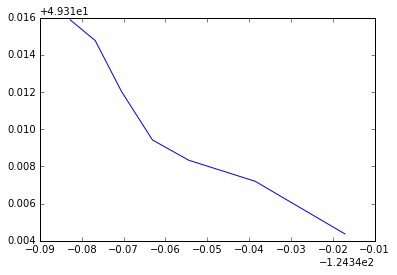

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(*line.coordinates)

Data can be read from several common formats, including ESRI shapefiles (through
bindings to the *pyshp* module), GeoJSON, GPX, and comma separated value tables.
Convenience functions are kept in the `karta.vector.read` namespace.

Each geometry has appropriate methods to save data:

In [23]:
line.to_shapefile("my_shapefile")
poly.to_geojson("my_json.json")

## Raster data

Raster data are primarily represented by the `karta.RegularGrid` class. `RegularGrid` instances have a CRS, a Null-data value, a geotransform, and one or more *bands*, which containing the actual data.

### Bands

To provide flexibility, different band instances are provided by `karta.raster.bands` using different strategies for data storage.

- The simplest case, `SimpleBand`, uses a numpy array to store all data. This makes it reasonably fast, but can use a lot of memory when opening multiple large rasters.
- The default case, `CompressedBand`, uses chunking and blosc compression to reduce the memory footprint of the raster data, at a small speed cost.
- Finally, `GdalFileBand` reads data directly from a valid GDAL datasource, using the least memory but performing the slowest.

> Note: `GdalFileBand` doesn't currently handle all raster operations supported by the other band types.

In [24]:
import numpy as np
from karta.raster import RegularGrid, SimpleBand, CompressedBand, read_gtiff

ls8 = read_gtiff("LC80080032016087LGN00_B2.TIF")
print(ls8.bands)     # list of one CompressedBand instance

In [25]:
# Print grid dimensions
print(ls8.size)

(9141, 9151)


In [26]:
# Print grid extent
print(ls8.extent)

(354000.0, 628500.0, 8648400.0, 8922600.0)


When opening or creating a `RegularGrid`, a non-default band type can be specified as a keyword argument.

In [27]:
# Specify the band backend and verify that the data are the same
ls8_numpy = read_gtiff("LC80080032016087LGN00_B2.TIF", bandclass=SimpleBand)
np.all(ls8[:,:] == ls8_numpy[:,:])    # True

True

In the above, the slice syntax `[:,:]` is used to get an array of all grid data. Because the grid `ls8` has only a single band in this case, the data array has two dimensions. The normal simple slicing rules apply, i.e. one can do things like:

In [28]:
subgrid = ls8[2000:3000, 4000:4500]
print(subgrid.shape)

(1000, 500)


In [29]:
every_other = ls8[::2, ::2]
print(every_other.shape)

(4571, 4576)


The `RegularGrid` instance provides methods for sampling rasters, computing statistics, clipping and resizing, and resampling.

**Note**

When getting raster data, the array provided by slicing is not necessarily a view of the underlying data, and may be a copy instead. Modifying the array is not guaranteed to modify the raster. When the raster data must be replaced by an element-wise computation, use the `Grid.apply(func)` method, which operates in-place. The `apply` method may be chained.

```
# Example
grid.apply(lambda x: x**2) \
    .apply(np.sin) \
    .apply(lambda x: np.where(x < 0.5, grid.nodata, x))
```

This handles nodata pixels automatically. If the raster data must be replaced by arbitrary data, set it explicitly with `Grid[:,:] = ...`.

```
# Example
grid[:,:] = np.convolve(np.ones([3,3])/9.0, grid[:,:], mode='same')
```

New `RegularGrid` instances are created by specifying a geotransform. The geotransform is represented by a tuple of the form
```
transform = (xll, yll, dx, dy, sx, sy)
```
where `xll` and `yll` are the coordinates of the lower left grid corner, `dx` and `dy` specify resolution, and `sx` and `sy` specify grid skew and rotation.

Additional arguments define the grid size and coordinate reference system, and initialize grid data. The following creates a "north-up" orthogonal grid with uniform spacing of 10 meters and an origin at (0, 0).

In [30]:
from karta.crs import WebMercator
grid = RegularGrid([0, 0, 10.0, 10.0, 0.0, 0.0],
                   values=np.zeros([1000, 1000]),
                   nodata_value=np.nan,
                   crs=WebMercator)

In [31]:
grid.resolution

(10.0, 10.0)

In [32]:
grid.extent

(5.0, 9995.0, 5.0, 9995.0)

In [33]:
grid.bbox

(0.0, 0.0, 10000.0, 10000.0)